In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [2]:
date = '20220512'
dataNo = 6
scanNo = 6

In [3]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [4]:
param_name = 'A0157: OL (H1): AM for physics 2'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[5]
sample3 = unique_param[9]
unit = '[V]'
flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [5]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '7.0[V]')

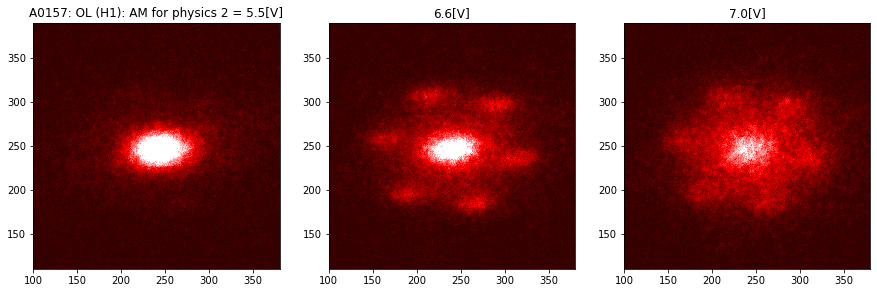

In [9]:
vmin = 0
vmax = 700
xlim_1 = 100
xlim_2 = 380
ylim_1 = 110
ylim_2 = 390

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [10]:
img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            img_temp.append(img_trans_list[j])
    img_ave_by_unique_param.append(np.average(img_temp, axis=0))

In [11]:
change = True
while change:
    change = False
    for i in range(len(unique_param)-1):
        if unique_param[i]>unique_param[i+1]:
            unique_param[i], unique_param[i+1] = unique_param[i+1], unique_param[i]
            img_ave_by_unique_param[i], img_ave_by_unique_param[i+1] = img_ave_by_unique_param[i+1], img_ave_by_unique_param[i]
            change = True

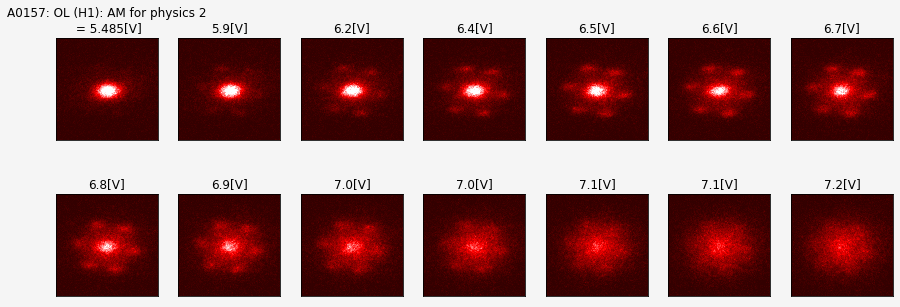

In [17]:
vmin = 0
vmax = 900

column_number = 7
row_number = 2

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)

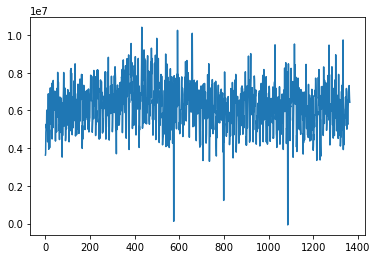

In [18]:
flCount = scan_data['Total count1 @ ROI1 (arb. u.)']
plt.plot(flCount)

In [20]:
postSelected_trans_files = []
postSelected_img_trans_list = []
postSelected_scan_param_list = []
threshold = 2e06

for i in range(len(trans_files)):
    if flCount[i] > threshold:
        postSelected_trans_files.append(trans_files[i])
        postSelected_img_trans_list.append(img_trans_list[i])
        postSelected_scan_param_list.append(scan_param[i])

In [23]:
postSelected_img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(postSelected_trans_files)):
        if postSelected_scan_param_list[j] == unique_param[i]:
            img_temp.append(postSelected_img_trans_list[j])
    postSelected_img_ave_by_unique_param.append(np.average(img_temp, axis=0))

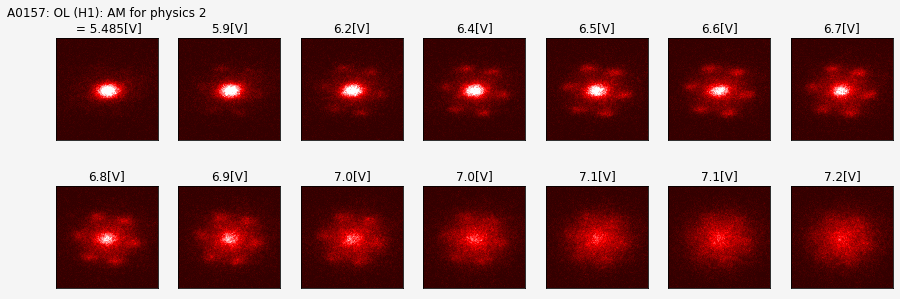

In [24]:
column_number = 7
row_number = 2


fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(postSelected_img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)

In [25]:
unique_param_index = 2

def createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index):
    unique_trans_files = []
    for i in range(len(img_trans_list)):
        if scan_param[i] == unique_param[unique_param_index]:
            unique_trans_files.append(img_trans_list[i])
    return unique_trans_files

unique_trans_files = createUniqueTransFiles(postSelected_img_trans_list, postSelected_scan_param_list, unique_param, unique_param_index)

In [30]:
cx = 245
cy = 245
r = 8
momentum_peaks_C1_dx_list = [30, -31, 8]
momentum_peaks_C1_dy_list = [-20, -9, 31]
momentum_peaks_C2_dx_list = [-5, 35, -27]
momentum_peaks_C2_dy_list = [-29, 12, 24]

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

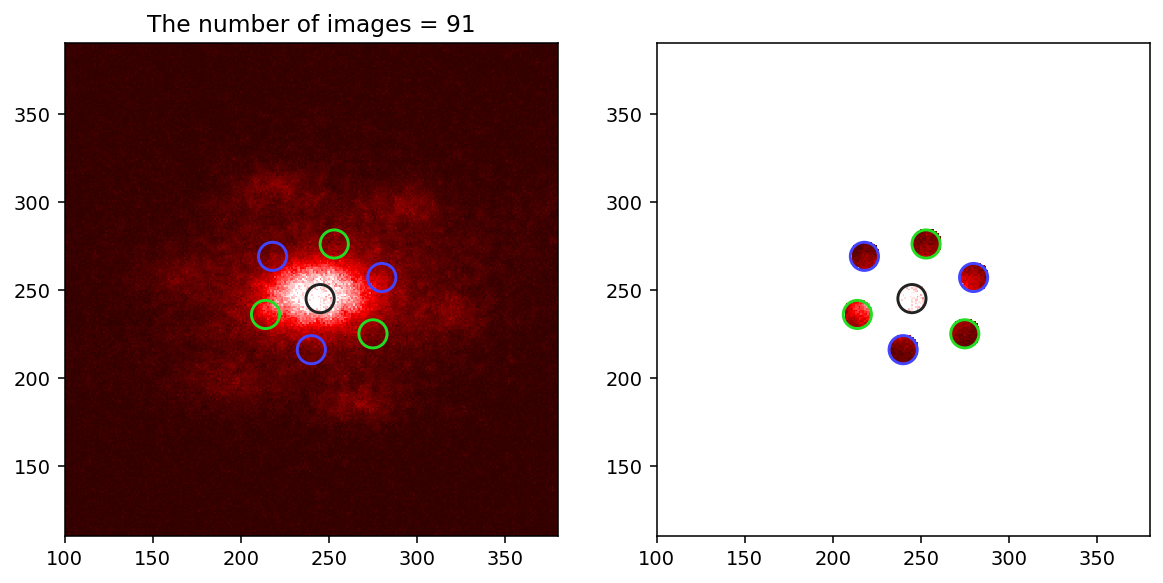

In [31]:
vmin = 0
vmax = 1000
fig =plt.figure(figsize=[10,5],dpi = 140)
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(unique_trans_files)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(subROI_cx_list)):
    ax2.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i == 0:
        color = '#222222'
    elif i<4:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=1.5)
    region.plot(ax=ax2, color=color, lw=1.5)

In [32]:
def calculateVisibility(trans_files, subROI_cx_list, subROI_cy_list, r):
    center_list = []
    side1_list = []
    side2_list = []
    visibility_list = []
    for j in range(len(trans_files)):
        center_list.append(OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[0], subROI_cy_list[0],r))
        side1_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(1,4,1)))))
        side2_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(4,7,1)))))
        visibility_list.append((side1_list[-1]-side2_list[-1])/(side1_list[-1]+side2_list[-1]))
    x_list = np.arange(0,len(unique_trans_files),1)
    return x_list, visibility_list

x_list, visibility_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)

Text(0.5, 0, 'Number of occurence')

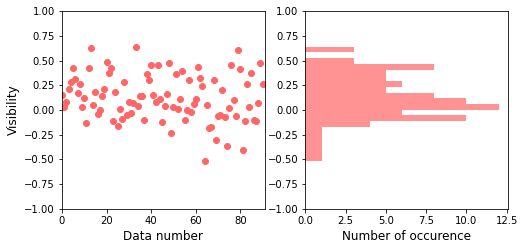

In [33]:
fig =plt.figure(figsize=[8,8])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(unique_trans_files))
# ax3.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax3.set_ylim(-1,1)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
# ax4.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax4.set_ylim(-1,1)
ax4.set_xlabel('Number of occurence',fontsize=12)

In [34]:
threshold = 0.0

def createChiralImages(trans_files, visibility_list, threshold):
    image1_list = []
    image2_list = []
    for i in range(len(trans_files)):
        if visibility_list[i] < -threshold:
            image1_list.append(trans_files[i])
        elif visibility_list[i] > threshold:
            image2_list.append(trans_files[i])
    image1_ave = np.average(image1_list, axis=0)
    image2_ave = np.average(image2_list, axis=0)
    return image1_ave, image2_ave, len(image1_list), len(image2_list)

post_selected_images = createChiralImages(unique_trans_files, visibility_list, threshold)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

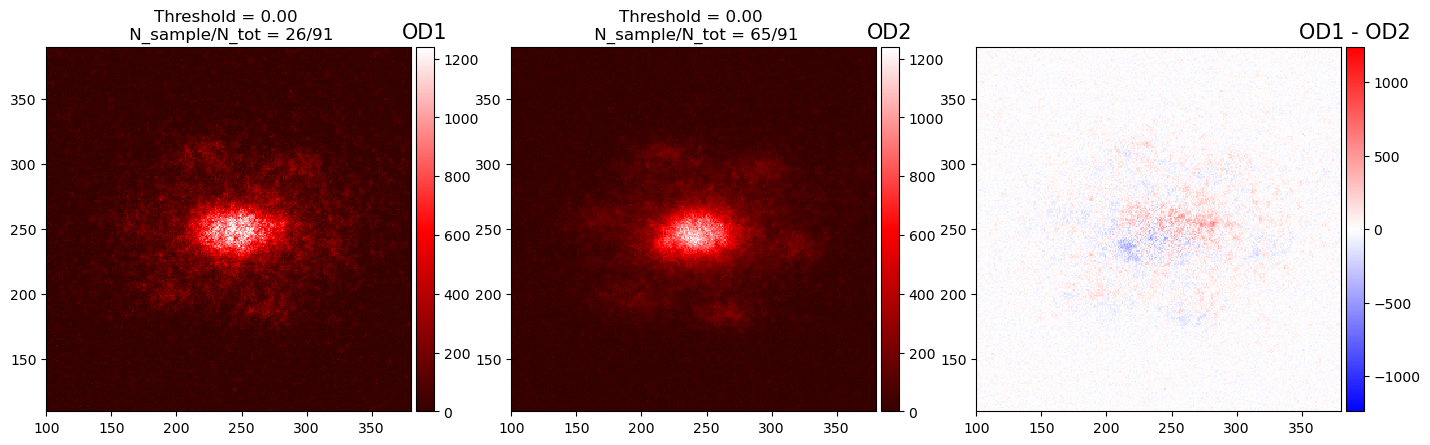

In [35]:
vmin = 00
vmax = 0.8*np.max(post_selected_images[0])
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )


fig =plt.figure(figsize=[17,5],dpi=100)
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(post_selected_images[0], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.02f \n N_sample/N_tot = %d/%d"%(threshold, post_selected_images[2], len(unique_trans_files)))
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"OD1", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
mappable = ax2.pcolormesh(post_selected_images[1], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("Threshold = %.02f \n N_sample/N_tot = %d/%d"%(threshold, post_selected_images[3], len(unique_trans_files)))
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"OD2", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
mappable =ax3.pcolormesh(post_selected_images[0] - post_selected_images[1],cmap='bwr', norm=norm, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
divider3 = make_axes_locatable(ax3)
ax_cb3 = divider3.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb3)
pp.ax.set_title(r"OD1 - OD2", fontsize=15)

plt.tight_layout

In [36]:
number_of_unique_trans_files = []
hist_list = []
chiral_imgs_list = []

momentum_peaks_C1_dx_list = [30, -31, 8]
momentum_peaks_C1_dy_list = [-20, -9, 31]
momentum_peaks_C2_dx_list = [-5, 35, -27]
momentum_peaks_C2_dy_list = [-29, 12, 24]
cx = 245
cy = 245
r = 8

threshold = 0.0

for i in range(len(unique_param)):
    unique_param_index = i
    print(i)
    
    unique_trans_files = createUniqueTransFiles(postSelected_img_trans_list, postSelected_scan_param_list, unique_param, unique_param_index)
    number_of_unique_trans_files.append(len(unique_trans_files))
    subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)
    hist_list.append(calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r))
    chiral_imgs_list.append(createChiralImages(unique_trans_files, hist_list[-1][1], threshold))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


c:\Users\Lab\anaconda3\envs\qgm1\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


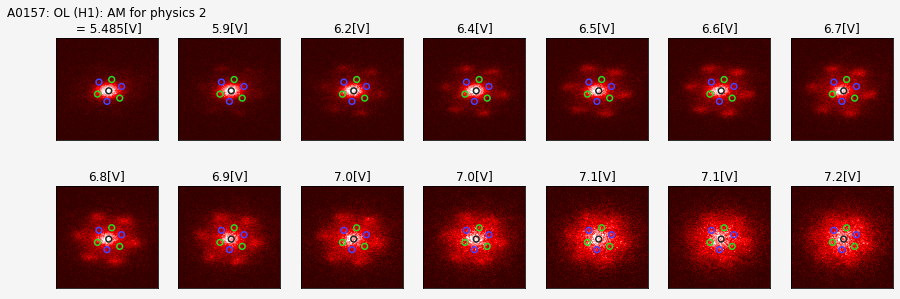

In [39]:
column_number = 7
row_number = 2


fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)
            vmax = 0.8*np.max(postSelected_img_ave_by_unique_param[column_number*i+j])
            axes[i,j].pcolormesh(postSelected_img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)
            for k in range(len(subROI_cx_list)):
                if k == 0:
                    color = '#222222'
                elif k<4:
                    color = '#22dd22'
                else:
                    color = '#4444ff'
                region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[k], y=subROI_cy_list[k]), radius=r)
                region.plot(ax=axes[i,j], color=color, lw=1.5)
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

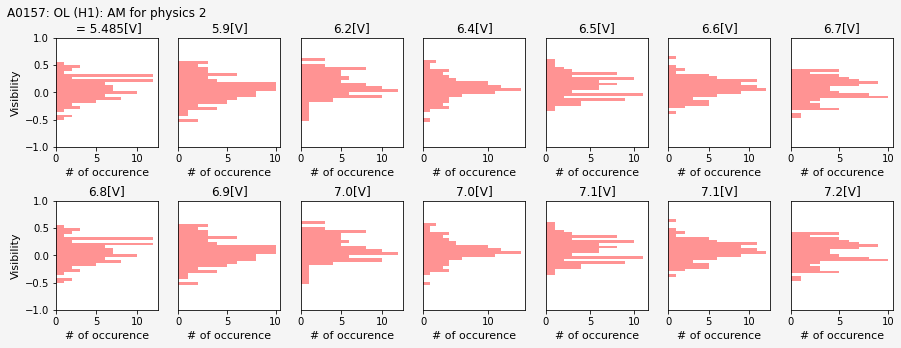

In [40]:
fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].hist(np.array(hist_list[j][1]),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
            axes[i,j].set_ylim(-1,1)
            axes[i,j].set_xlabel('# of occurence',fontsize=11)
            if j == 0:
                axes[i,j].set_ylabel('Visibility',fontsize=11)
            elif j>0:
                axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)

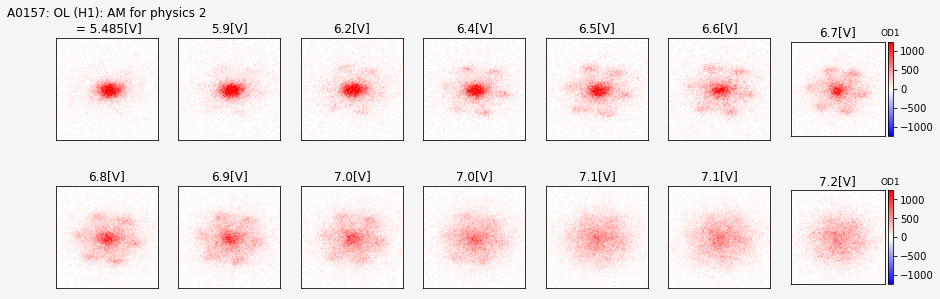

In [42]:
vmax = 1000
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(chiral_imgs_list[column_number*i+j][0],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)
            if j == column_number-1:
                divider1 = make_axes_locatable(axes[i,j])
                ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
                pp=fig.colorbar(mappable,cax=ax_cb1)
                pp.ax.set_title(r"OD1", fontsize=9)
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

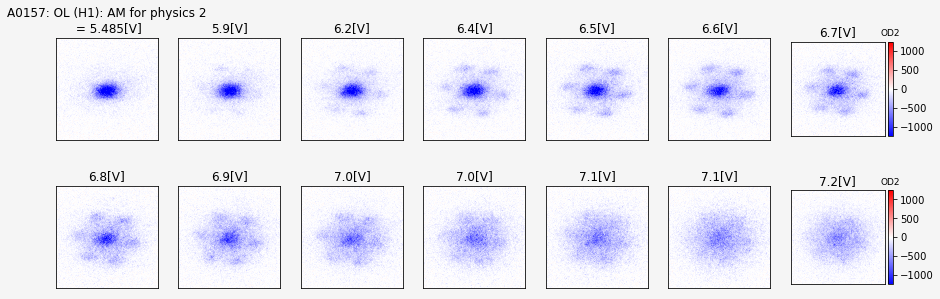

In [43]:
fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(-chiral_imgs_list[column_number*i+j][1],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)
            if j == column_number-1:
                divider1 = make_axes_locatable(axes[i,j])
                ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
                pp=fig.colorbar(mappable,cax=ax_cb1)
                pp.ax.set_title(r"OD2", fontsize=9)
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

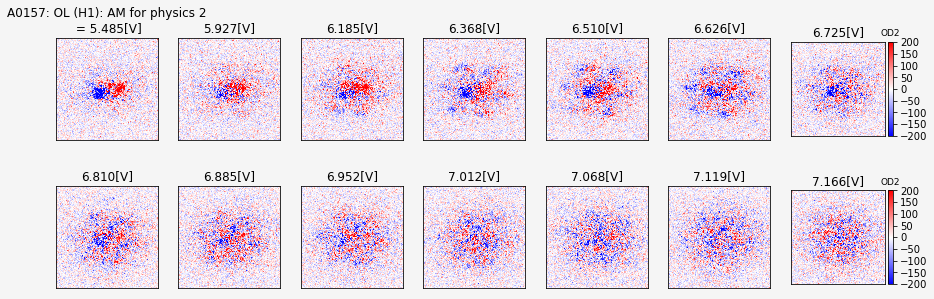

In [45]:
vmax = 200
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            mappable = axes[i,j].pcolormesh(chiral_imgs_list[column_number*i+j][0] - chiral_imgs_list[column_number*i+j][1],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.03f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.03f"%(unique_param[column_number*i+j])+unit)
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
        if j ==  column_number-1:
            divider1 = make_axes_locatable(axes[i,j])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            pp.ax.set_title(r"OD2", fontsize=9)